In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import pustaka yang diperlukan

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.initializers import glorot_normal

# Download data untuk pemrosesan
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import Data

In [158]:
df = pd.read_csv("/content/drive/MyDrive/Dicoding/PENGEMBANGAN MACHINE LEARNING/PROYEK 1 - NLP/twitter_training.csv")
df.columns = ['id', 'information', 'label', 'text']
df.head()

,id,information,label,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74681 non-null  int64 
 1   information  74681 non-null  object
 2   label        74681 non-null  object
 3   text         73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [160]:
df.nunique()

id             12447
information       32
label              4
text           69490
dtype: int64

In [161]:
# Menghapus kolom 'id' dan 'information'
df.drop(['id', 'information'], axis=1, inplace=True)
df.head()

,label,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [162]:
# Cek isi kolom 'label'
df.label.value_counts()

Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: label, dtype: int64

In [163]:
# Cek missing value
df.isna().sum()

label      0
text     686
dtype: int64

In [164]:
# Menghapus baris yang mengandung missing value
df.dropna(inplace=True)

# Menampilkan informasi tentang missing value setelah penghapusan
print("\nJumlah missing value setelah penghapusan:")
print(df.isnull().sum())


Jumlah missing value setelah penghapusan:
label    0
text     0
dtype: int64


In [165]:
# Cek Duplicate
df.duplicated().sum()

4227

In [166]:
# Menghapus baris yang merupakan duplikat
df.drop_duplicates(inplace=True)

# Menampilkan jumlah duplikat setelah penghapusan
print("Jumlah duplikat setelah penghapusan:", df.duplicated().sum())

Jumlah duplikat setelah penghapusan: 0


In [167]:
# Reset indeks setelah menghapus nilai yang hilang dan duplikat
df.reset_index(drop=True, inplace=True)
df.head()

,label,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [168]:
df.shape

(69768, 2)

# Exploratory Data Analysis

Membuat Plot Representasi Label

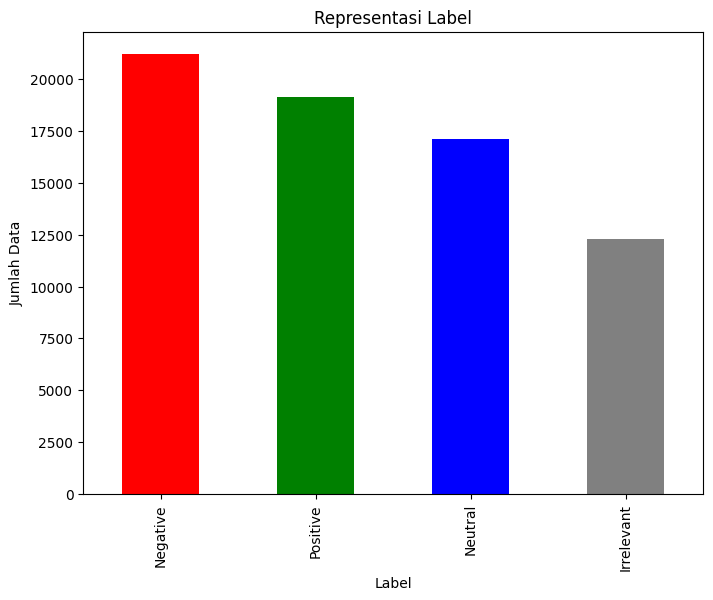

In [169]:
# Menghitung jumlah data pada setiap kategori label
label_counts = df['label'].value_counts()

# Membuat plot bar untuk representasi label
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['red', 'green', 'blue', 'gray'])
plt.title('Representasi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.show()

Membuat plot kata yang sering muncul untuk setiap kategori label

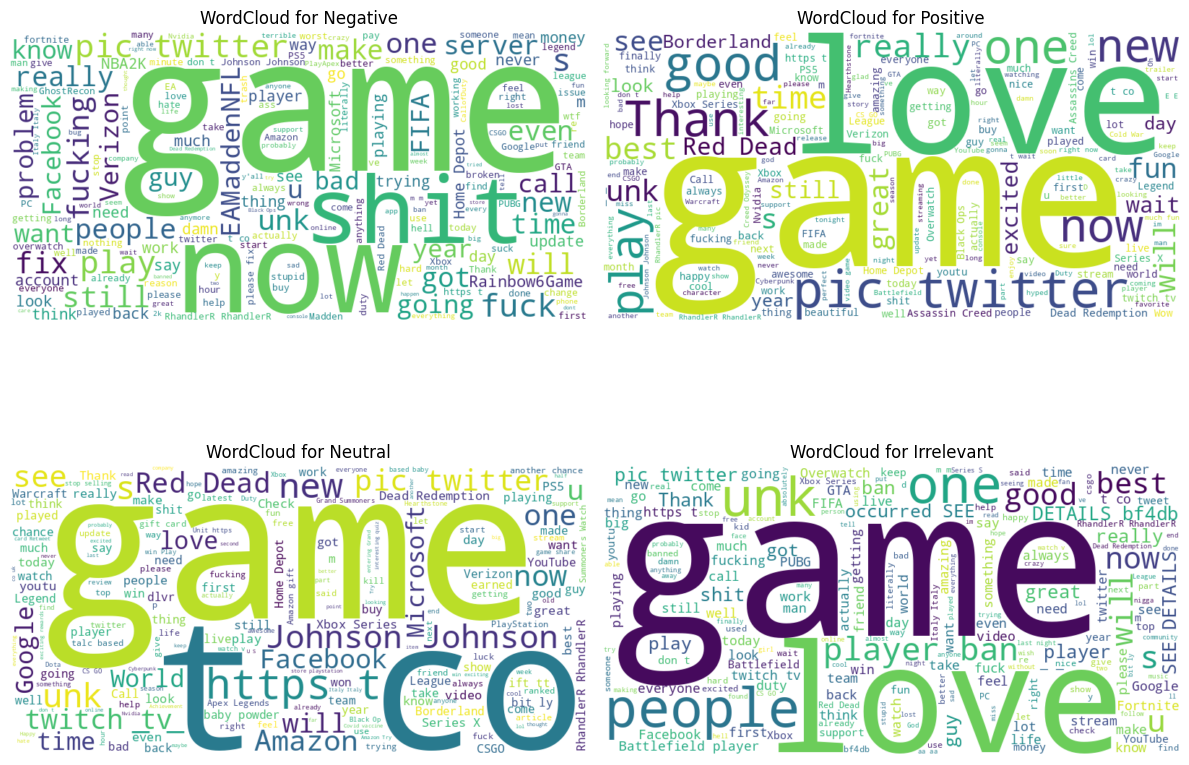

In [170]:
# Mengelompokkan teks berdasarkan label
negative_text = ' '.join(df[df['label'] == 'Negative']['text'])
positive_text = ' '.join(df[df['label'] == 'Positive']['text'])
neutral_text = ' '.join(df[df['label'] == 'Neutral']['text'])
irrelevant_text = ' '.join(df[df['label'] == 'Irrelevant']['text'])

# Membuat WordCloud untuk setiap label
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)
wordcloud_irrelevant = WordCloud(width=800, height=400, background_color='white').generate(irrelevant_text)

# Menampilkan WordCloud
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('WordCloud for Negative')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('WordCloud for Positive')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('WordCloud for Neutral')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(wordcloud_irrelevant, interpolation='bilinear')
plt.title('WordCloud for Irrelevant')
plt.axis('off')

plt.tight_layout()
plt.show()

# Membuat fungsi untuk membersihkan teks

In [171]:
def clean_text(text):
    # Konversi teks ke lowercase
    text = text.lower()
    # Menghilangkan tanda baca dan mengubah teks menjadi kata-kata
    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(text)

    # Menghilangkan stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in tokens if word.lower() not in stop_words]

    return " ".join(filtered_words)

# Mengaplikasikan fungsi preprocess_text pada kolom 'text'
df['text'] = df['text'].apply(clean_text)

# Dataset Splitting

In [172]:
# Membagi data menjadi data train dan data test
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55814,), (13954,), (55814,), (13954,))

# Tokenisasi dan Padding

In [173]:
# Tokenisasi hanya pada data train
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Mengubah teks menjadi sequence
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Menentukan panjang maksimal berdasarkan data train
max_length = max([len(x) for x in train_sequences])

# Melakukan padding pada kedua set data
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='pre')
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='pre')

# Preprocessing Label

In [174]:
# Label Encoding dan One-hot Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Membangun Model Sequential dengan LSTM

In [176]:
# Membangun model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 200, input_length=max_length, embeddings_initializer=glorot_normal()))
model.add(LSTM(100, return_sequences=True, dropout=0.6))
model.add(LSTM(100, dropout=0.6))
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training Model

In [179]:
# Callback untuk early stopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Melatih model
history = model.fit(
    X_train_padded, y_train_categorical,
    epochs=10, batch_size=32,
    callbacks=[callback],
    validation_data=(X_test_padded, y_test_categorical))

Epoch 1/10
1745/1745 [==============================] - 35s 20ms/step - loss: 0.2588 - accuracy: 0.9078 - val_loss: 0.3181 - val_accuracy: 0.8871
Epoch 4/10
1745/1745 [==============================] - 33s 19ms/step - loss: 0.2056 - accuracy: 0.9262 - val_loss: 0.3113 - val_accuracy: 0.8951
Epoch 5/10
1745/1745 [==============================] - 33s 19ms/step - loss: 0.1733 - accuracy: 0.9364 - val_loss: 0.2982 - val_accuracy: 0.9017
Epoch 6/10
1745/1745 [==============================] - 33s 19ms/step - loss: 0.1478 - accuracy: 0.9460 - val_loss: 0.2889 - val_accuracy: 0.9075
Epoch 7/10
1745/1745 [==============================] - 32s 18ms/step - loss: 0.1285 - accuracy: 0.9533 - val_loss: 0.2997 - val_accuracy: 0.9066
Epoch 8/10
1745/1745 [==============================] - 32s 19ms/step - loss: 0.1183 - accuracy: 0.9572 - val_loss: 0.2938 - val_accuracy: 0.9116
Epoch 9/10
1745/1745 [==============================] - 32s 18ms/step - loss: 0.1066 - accuracy: 0.9606 - val_loss: 0.3070 -

# Evaluasi Model

In [182]:
# Evaluasi model pada data training
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train_categorical)
print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy*100:.2f}%')

# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_categorical)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')


1745/1745 [==============================] - 12s 7ms/step - loss: 0.0877 - accuracy: 0.9688
Training Loss: 0.0877
Training Accuracy: 96.88%
437/437 [==============================] - 4s 9ms/step - loss: 0.2889 - accuracy: 0.9075
Test Loss: 0.2889
Test Accuracy: 90.75%


# Visualisasi Hasil Training

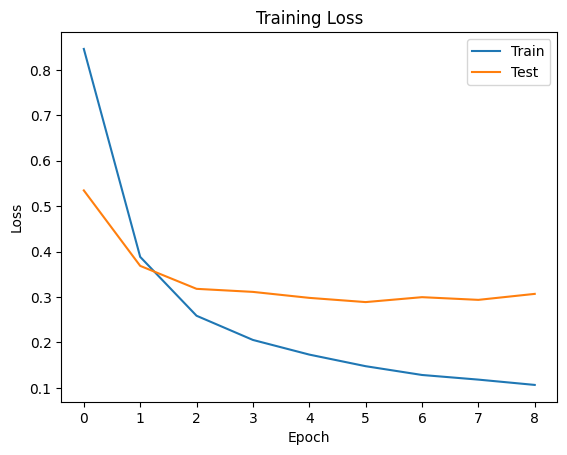

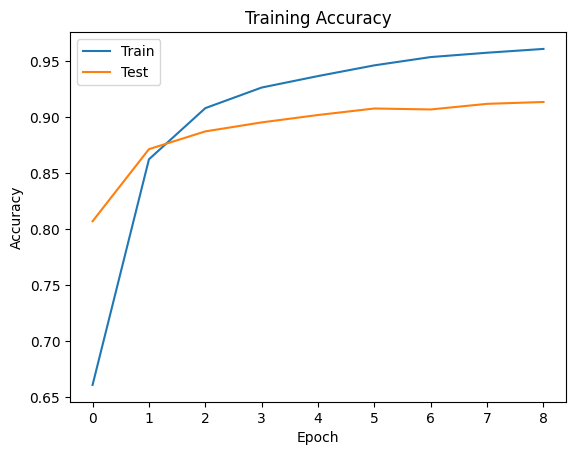

In [185]:
# Visualization of Training Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualization of Training Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()